**Задача** - предсказать рейтинг энергопотребления (Energy Star Score) здания и понять, какие признаки оказывают на него сильнейшее влияние.

**Датасет** - открытые сведения о энергопотреблении зданий в Нью-Йорке.

Данные уже содержат в себе Energy Star Score, так что задача относится к классу задач машинного обучения с учителем, и представляет собой построение регрессии:

*Обучение с учителем:* у нас есть как все необходимые признаки, на основе которых выполняется предсказание, так и сам целевой признак.

*Регрессия:* будем считать, что рейтинг энергопоребления — это непрерывная величина. 

# Импорт и предобработка данных

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

data.head(4)

Order  Property Id                                 Property Name  \
0      1        13286                                       201/205   
1      2        28400                    NYP Columbia (West Campus)   
2      3      4778226                                 MSCHoNY North   
3      4      4778267  Herbert Irving Pavilion & Millstein Hospital   

  Parent Property Id        Parent Property Name BBL - 10 digits  \
0              13286                     201/205      1013160001   
1              28400  NYP Columbia (West Campus)      1021380040   
2              28400  NYP Columbia (West Campus)      1021380030   
3              28400  NYP Columbia (West Campus)      1021390001   

  NYC Borough, Block and Lot (BBL) self-reported  \
0                                     1013160001   
1                                   1-02138-0040   
2                                   1-02138-0030   
3                                   1-02139-0001   

            NYC Building Identification Number (BIN)  \
0                                            1037549   
1  1084198; 1084387;1084385; 1084386; 1084388; 10...   
2                                            1063380   
3                                   1087281; 1076746   

  Address 1 (self-reported)                Address 2  \
0  201/205  East  42nd  st.            Not Available   
1          622 168th Street            Not Available   
2             3975 Broadway            Not Available   
3   161 Fort Washington Ave  177 Fort Washington Ave   

                         ...                         Source EUI (kBtu/ft²)  \
0                        ...                                         619.4   
1                        ...                                         404.3   
2                        ...                                 Not Available   
3                        ...                                 Not Available   

             Release Date Water Required? DOF Benchmarking Submission Status  \
0  05/01/2017 05:32:03 PM              No                      In Compliance   
1  04/27/2017 11:23:27 AM              No                      In Compliance   
2  04/27/2017 11:23:27 AM              No                      In Compliance   
3  04/27/2017 11:23:27 AM              No                      In Compliance   

    Latitude  Longitude Community Board Council District Census Tract  \
0  40.750791 -73.973963             6.0              4.0         88.0   
1  40.841402 -73.942568            12.0             10.0        251.0   
2  40.840427 -73.940249            12.0             10.0        251.0   
3  40.840746 -73.942854            12.0             10.0        255.0   

                                                 NTA  
0  Turtle Bay-East Midtown                       ...  
1  Washington Heights South                      ...  
2  Washington Heights South                      ...  
3  Washington Heights South                      ...  

[4 rows x 60 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11735 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

Датасет содержит **60 признаков**, наш целевой признак - это **ENERGY STAR Score**. Он представляет собой оценку в баллах от 1 до 100, основанную на предоставленных сведениях о потреблении электроэнергии. Рейтинг энергопотребления это относительная величина, используемая для сравнения эффективности использования энергии различными зданиями.

**Первая проблема** - пропущенные данные, вставленные в набор, выглядят как строка с записью “Not Available”. Это означает, что Python, даже если эта колонка содержит в себе преимущественно числовые признаки, будет интерпретировать её как тип данных object, потому что Pandas интерпретируют любой признак содержащий строковые значения как строку. 

Очевидно, многие признаки, являющиеся изначально числовыми (например, площади), интерпретированы как object. Анализировать их крайне сложно, так что сначала конвертируем их в числа, а именно в тип float.

Заменим значение "Not Available" в данных на "not a number" (np.nan), которое Python все же интерпретирует как число. Это позволит изменить тип соответствующих числовых признаков на float:

In [5]:
data = data.replace({'Not Available': np.nan})

for col in list(data.columns):
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        data[col] = data[col].astype(float)

In [6]:
data.describe()

Order   Property Id  DOF Gross Floor Area  \
count  11746.000000  1.174600e+04          1.162800e+04   
mean    7185.759578  3.642958e+06          1.732695e+05   
std     4323.859984  1.049070e+06          3.367055e+05   
min        1.000000  7.365000e+03          5.002800e+04   
25%     3428.250000  2.747222e+06          6.524000e+04   
50%     6986.500000  3.236404e+06          9.313850e+04   
75%    11054.500000  4.409092e+06          1.596140e+05   
max    14993.000000  5.991312e+06          1.354011e+07   

       Largest Property Use Type - Gross Floor Area (ft²)  \
count                                       1.174400e+04    
mean                                        1.605524e+05    
std                                         3.095746e+05    
min                                         5.400000e+01    
25%                                         6.520100e+04    
50%                                         9.132400e+04    
75%                                         1.532550e+05    
max                                         1.421712e+07    

       2nd Largest Property Use - Gross Floor Area (ft²)  \
count                                        3741.000000   
mean                                        22778.682010   
std                                         55094.441422   
min                                             0.000000   
25%                                          4000.000000   
50%                                          8654.000000   
75%                                         20000.000000   
max                                        962428.000000   

       3rd Largest Property Use Type - Gross Floor Area (ft²)    Year Built  \
count                                        1484.000000       11746.000000   
mean                                        12016.825270        1948.738379   
std                                         27959.755486          30.576386   
min                                             0.000000        1600.000000   
25%                                          1720.750000        1927.000000   
50%                                          5000.000000        1941.000000   
75%                                         12000.000000        1966.000000   
max                                        591640.000000        2019.000000   

       Number of Buildings - Self-reported     Occupancy  ENERGY STAR Score  \
count                         11746.000000  11746.000000        9642.000000   
mean                              1.289971     98.762557          59.854594   
std                               4.017484      7.501603          29.993586   
min                               0.000000      0.000000           1.000000   
25%                               1.000000    100.000000          37.000000   
50%                               1.000000    100.000000          65.000000   
75%                               1.000000    100.000000          85.000000   
max                             161.000000    100.000000         100.000000   

           ...        Indirect GHG Emissions (Metric Tons CO2e)  \
count      ...                                     1.168100e+04   
mean       ...                                     2.076339e+03   
std        ...                                     5.931295e+04   
min        ...                                    -2.313430e+04   
25%        ...                                     9.480000e+01   
50%        ...                                     1.718000e+02   
75%        ...                                     4.249000e+02   
max        ...                                     4.764375e+06   

       Property GFA - Self-Reported (ft²)  \
count                        1.174600e+04   
mean                         1.673739e+05   
std                          3.189238e+05   
min                          0.000000e+00   
25%                          6.699400e+04   
50%                          9.408000e+04   
75%                          1.584140e+05   
max

## Пропущенные данные и выбросы
В добавок к некорректному определению типов данных, другая проблема — это пропуски в данных. У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. 

Ниже представлена функция, определяющая пропущенные значения в числовом и процентном выражении.

In [7]:
def missing_values_table(df):
        # Все пропущенные значения
        mis_val = df.isnull().sum()
        
        # Процент пропущенных
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Отсортированные данные по процентам
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [8]:
missing_values_table(data)

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.


Missing Values  \
Fuel Oil #1 Use (kBtu)                                       11737   
Diesel #2 Use (kBtu)                                         11730   
Address 2                                                    11539   
Fuel Oil #5 & 6 Use (kBtu)                                   11152   
District Steam Use (kBtu)                                    10810   
Fuel Oil #4 Use (kBtu)                                       10425   
3rd Largest Property Use Type - Gross Floor Are...           10262   
3rd Largest Property Use Type                                10262   
Fuel Oil #2 Use (kBtu)                                        9165   
2nd Largest Property Use Type                                 8005   
2nd Largest Property Use - Gross Floor Area (ft²)             8005   
Metered Areas  (Water)                                        4609   
Water Intensity (All Water Sources) (gal/ft²)                 3984   
Water Use (All Water Sources) (kgal)                          3984   
Latitude                                                      2263   
Longitude                                                     2263   
Community Board                                               2263   
Council District                                              2263   
Census Tract                                                  2263   
NTA                                                           2263   
ENERGY STAR Score                                             2104   
Weather Normalized Site Natural Gas Intensity (...            1963   
Weather Normalized Site Natural Gas Use (therms)              1962   
Weather Normalized Source EUI (kBtu/ft²)                      1465   
Weather Normalized Site EUI (kBtu/ft²)                        1465   
Natural Gas Use (kBtu)                                        1442   
Weather Normalized Site Electricity Intensity (...             787   
Weather Normalized Site Electricity (kWh)                      786   
Electricity Use - Grid Purchase (kBtu)                         244   
Site EUI (kBtu/ft²)                                            163   
Source EUI (kBtu/ft²)                                          163   
NYC Building Identification Number (BIN)                       162   
Street Number                                                  124   
Street Name                                                    122   
Borough                                                        118   
DOF Gross Floor Area                                           118   
Water Required?                                                118   
Direct GHG Emissions (Metric Tons CO2e)                         83   
Total GHG Emissions (Metric Tons CO2e)                          74   
Indirect GHG Emissions (Metric Tons CO2e)                       65   
Metered Areas (Energy)                                          57   
DOF Benchmarking Submission Status                              30   
NYC Borough, Block and Lot (BBL) self-reported                  11   
BBL - 10 digits                                                 11   
Largest Property Use Type                                        2   
Largest Property Use Type - Gross Floor Area (ft²)               2   

                                                    % of Total Values  
Fuel Oil #1 Use (kBtu)                                           99.9  
Diesel #2 Use (kBtu)                                             99.9  
Address 2                                                        98.2  
Fuel Oil #5 & 6 Use (kBtu)                                       94.9  
District Steam Use (kBtu)                                        92.0  
Fuel Oil #4 Use (kBtu)                                           88.8  
3rd Largest Property Use Type - Gross Floor Are...               87.4  
3rd Largest Property Use Type                                    87.4  
Fuel Oil #2 Use (kBtu)                                           78.0  
2nd Largest Property Use Type            

Признаки, в которых пропусков слишком много вряд ли вообще могут пригодиться. В данном случае мы удаляем признаки, в которых пропусков больше 50%.
Остаётся 49 признаков.

In [9]:
# Выбираем колонки, где пропущено больше 50% значений
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
We will remove 11 columns.


In [10]:
# Удаляем колонки
data = data.drop(columns = list(missing_columns))

## Предварительный анализ данных
Предварительный анализ данных (Exploratory Data Analysis — EDA) — это процесс который можно продолжать до бесконечности, на этом этапе мы строим графики, ищем закономерности, аномалии или связи между признаками.

## Графики от одной переменной
Цель — это предсказание значения целевого признака, рейтинга энергопотребления (переименуем его в score в нашем наборе), так что целесообразно для начала понять, какое эта величина имеет распределение. Посмотрим на него, построив гистограмму с matplotlib.

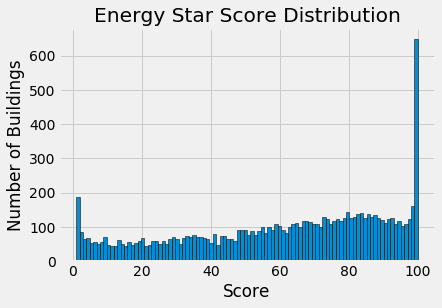

In [42]:
import matplotlib.pyplot as plt

# Rename the score 
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Гистограмма Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Number of Buildings');
plt.title('Energy Star Score Distribution');

Интересующий нас рейтинг представляет собой перцентиль, так что ожидаемо было бы увидеть равномерное распределение, где каждому значению соответствует примерно одинаковое количество зданий. Мы же видим диспропорцию - больше всего зданий имеют максимальное значение рейтинга — 100, либо минимальное — 1 (высокий рейтинг это хороший показатель).

Если мы вернемся к определению оценки, мы увидим, что она основана на самоотчете об использовании энергии. Это создает проблему, потому что у владельца здания может возникнуть соблазн сообщить о снижении потребления электроэнергии, чтобы искусственно повысить оценку своего здания. Это все равно что давать студентам оценку, основанную на самооценке результатов тестов. Такое поведение объясняет высокий процент зданий с идеальным счетом 100, но не объясняет, почему так много зданий забивают в самом низу.

Чтобы сопоставить показатель Energy Star, мы можем взглянуть на интенсивность использования энергии (EUI), которая представляет собой общее потребление энергии, деленное на квадратные метры здания. Здесь использование энергии не является самоотчетным, так что это может быть более объективной мерой энергоэффективности здания. Более того, это не процентильный ранг, поэтому абсолютные значения важны, и мы ожидаем, что они будут приблизительно нормально распределены, возможно, с несколькими выбросами на нижнем или высоком конце.

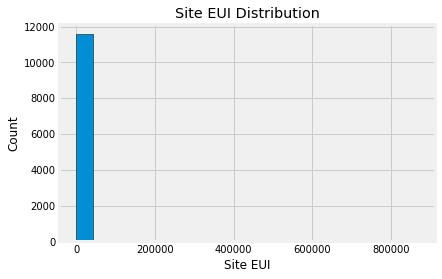

In [12]:
# Histogram Plot of Site EUI
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Site EUI Distribution');

Cтоит избавиться от выбросов. Они могут быть связаны с опечатками, ошибками в единицах измерения или являться корректными, но чересчур экстремальными значениями. Мы удаляем аномальные значения, полагаясь на данный критерий:

* Ниже первой квартили, минус 3 ∗ межквартильных расстояния
* Выше третьей квартили, плюс 3 ∗ межквартильных расстояния

На этом этапе в наборе остается более 11,000 записей (строений).

In [13]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [14]:
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10)

3173     51328.8
3170     51831.2
3383     78360.1
8269     84969.6
3263     95560.2
8268    103562.7
8174    112173.6
3898    126307.4
7       143974.4
8068    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64

In [15]:
data.loc[data['Site EUI (kBtu/ft²)'] == 869265, :]

Order  Property Id Property Name                   Parent Property Id  \
8068   9984      4414323  234 Skillman  Not Applicable: Standalone Property   

                     Parent Property Name BBL - 10 digits  \
8068  Not Applicable: Standalone Property      3028937502   

     NYC Borough, Block and Lot (BBL) self-reported  \
8068                                     3028937502   

     NYC Building Identification Number (BIN) Address 1 (self-reported)  \
8068                        3390250 , 3338313       234 Skillman avenue   

     Postal Code                        ...                          \
8068       11211                        ...                           

     Source EUI (kBtu/ft²)            Release Date Water Required?  \
8068              912801.1  05/01/2017 11:34:14 PM             NaN   

      DOF Benchmarking Submission Status   Latitude Longitude Community Board  \
8068                       In Compliance  40.716233 -73.94141             1.0   

      Council District  Census Tract  \
8068              34.0         477.0   

                                                    NTA  
8068  East Williamsburg                             ...  

[1 rows x 49 columns]

In [16]:
# Calculate first and third quartile
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]

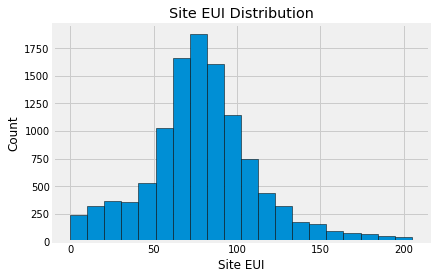

In [17]:
# Histogram Plot of Site EUI
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Site EUI Distribution');

## Поик отношений

Значительную часть работы на этапе EDA занимает поиск взаимосвязей между различными признаками. Очевидно, что признаки и значения признаков, оказывающие основное влияние на целевой, интересуют нас сильнее, чем прочие, по ним лучше всего и предсказывать значение целевого. Одним из способов оценить влияние значений категориальных признаков (число значений такого признака подразумевается конечным) на целевой — density plot, например, используя модуль seaborn.

Density plot можно представить себе как сглаженную гистограмму, потому что она показывает распределение одного значения категориально признака. Раскрасим распределения разными цветами и посмотрим на распределения. Код ниже строит density plot рейтинга энергопотребления. Разными цветами показаны рейтинги различных типов зданий (рассмотрены типы с как минимум сотней записей в нашем наборе):

C:\Users\DARIA\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


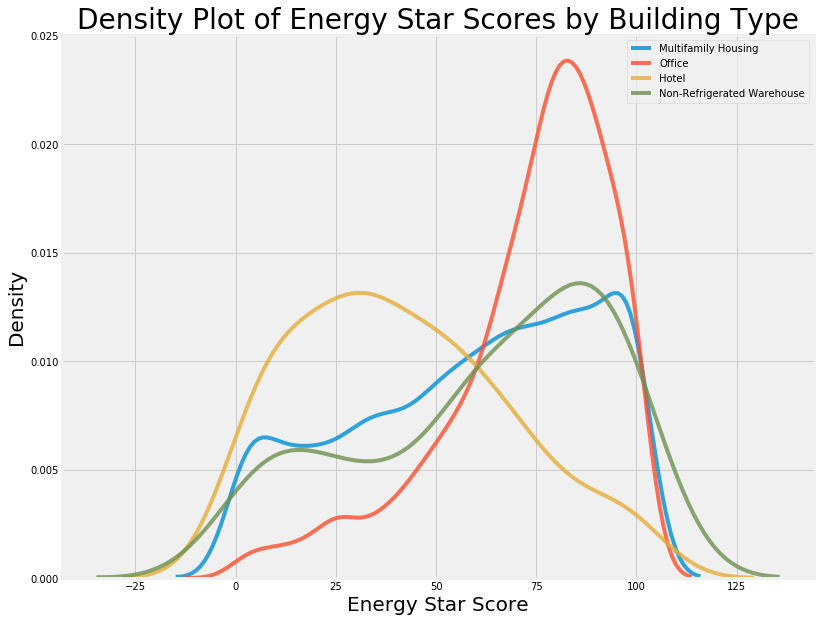

In [18]:
import seaborn as sns

# Create a list of buildings with more than 100 measurements
types = data.dropna(subset=['score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

# Plot of distribution of scores for building categories
fig = plt.figure(figsize=(12, 10))

# Plot each building
for b_type in types:
    # Select the building type
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28);

Видно, что тип здания оказывает существенное влияние на рейтинг энергопотребления. Здания, используемые как офисы, чаще имеют хороший рейтинг, а отели наоборот. Получается, такой признак, как тип здания, для нас важен. Так как это признак категориальный, нам ещё предстоит выполнить с ним так называемый «one-hot encode».

То же самое посмотрим для различных районов:

In [19]:
# Create a list of boroughs with more than 100 observations
boroughs = data.dropna(subset=['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

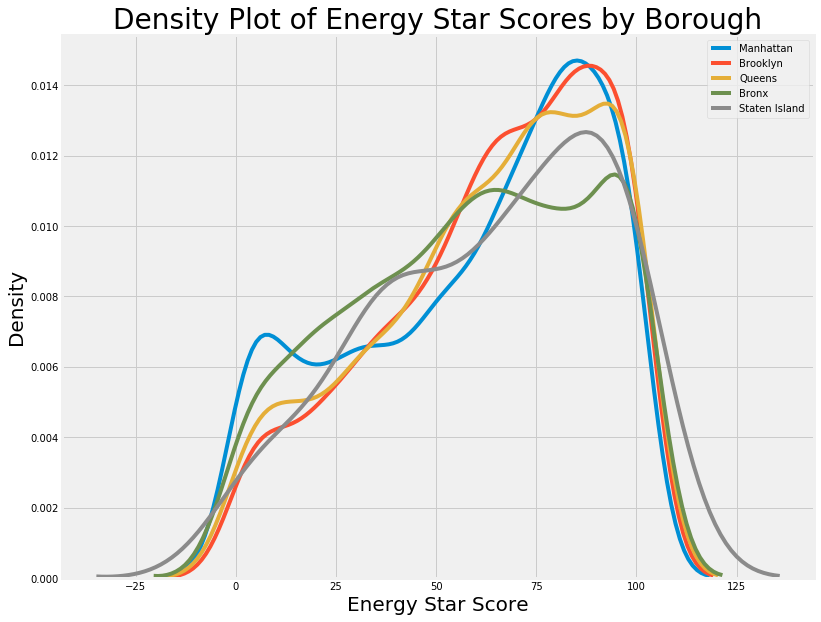

In [20]:
# Plot of distribution of scores for boroughs
fig = plt.figure(figsize=(12, 10))

# Plot each borough distribution of scores
for borough in boroughs:
    # Select the building type
    subset = data[data['Borough'] == borough]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = borough);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Borough', size = 28);

Район оказывает уже не такое большое влияние. Тем не менее, пожалуй, стоит включить этот признак в модель, так как определенная разница между районами все же есть.

Чтобы численно оценить степень влияния признаков можно использовать коэффициент корреляции Пирсона. Это мера степени и положительности линейных связей между двумя переменными.  Значение в +1 означает идеальную пропорциональность между значениями признаков и, соответственно, в -1 аналогично, но с отрицательным коэффициентом. 

In [21]:
# Find all correlations and sort 
correlations_data = data.corr()['score'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

In [45]:
# Выбираем числовые колонки
numeric_subset = data.select_dtypes('number')

for col in numeric_subset.columns:
    if col == 'score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Выбираем категориальные колонки
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Соединяем два датафрейма
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Удаляем строения без оценки
features = features.dropna(subset = ['score'])

# Ищем корреляцию и выполняем сортировку
correlations = features.corr()['score'].dropna().sort_values()

C:\Users\DARIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\DARIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\DARIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
C:\Users\DARIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__

In [44]:
# Вывод значений с наибольшей отрицательной корреляцией
correlations.head(15)

Site EUI (kBtu/ft²)                                            -0.723864
Weather Normalized Site EUI (kBtu/ft²)                         -0.713993
sqrt_Site EUI (kBtu/ft²)                                       -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.671044
sqrt_Source EUI (kBtu/ft²)                                     -0.669396
Weather Normalized Source EUI (kBtu/ft²)                       -0.645542
Source EUI (kBtu/ft²)                                          -0.641037
log_Source EUI (kBtu/ft²)                                      -0.622892
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.620329
log_Site EUI (kBtu/ft²)                                        -0.612039
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.601332
log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.424246
sqrt_Weather Normalized Site Electricity Intensity 

In [43]:
# Вывод значений с наибольшей положительной корреляцией
correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
log_Community Board                                                0.055495
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
log_Council District                                               0.061101
Council District                                                   0.061639
Largest Prop

Можно видеть что есть несколько признаков имеющих высокие отрицательные значения коэффициента Пирсона, с самой большой корреляцией для разных категорий EUI. EUI — Energy Use Intensity — это количество использованной энергии, разделенное на площадь помещений в квадратных футах. Значит, чем этот признак ниже, тем лучше. Соответственно: с ростом EUI, рейтинг энергопотребления становится ниже.

## Графики от двух переменных

Чтобы посмотреть на связь между двумя непрерывными переменными, можно использовать scatterplots (точечные графики). Дополнительную информацию, такую как значения категориальных признаков, можно показывать различными цветами. График снизу показывает разброс рейтинга энергопотребления в зависимости от величины Site EUI, а разными цветами показаны типы зданий:

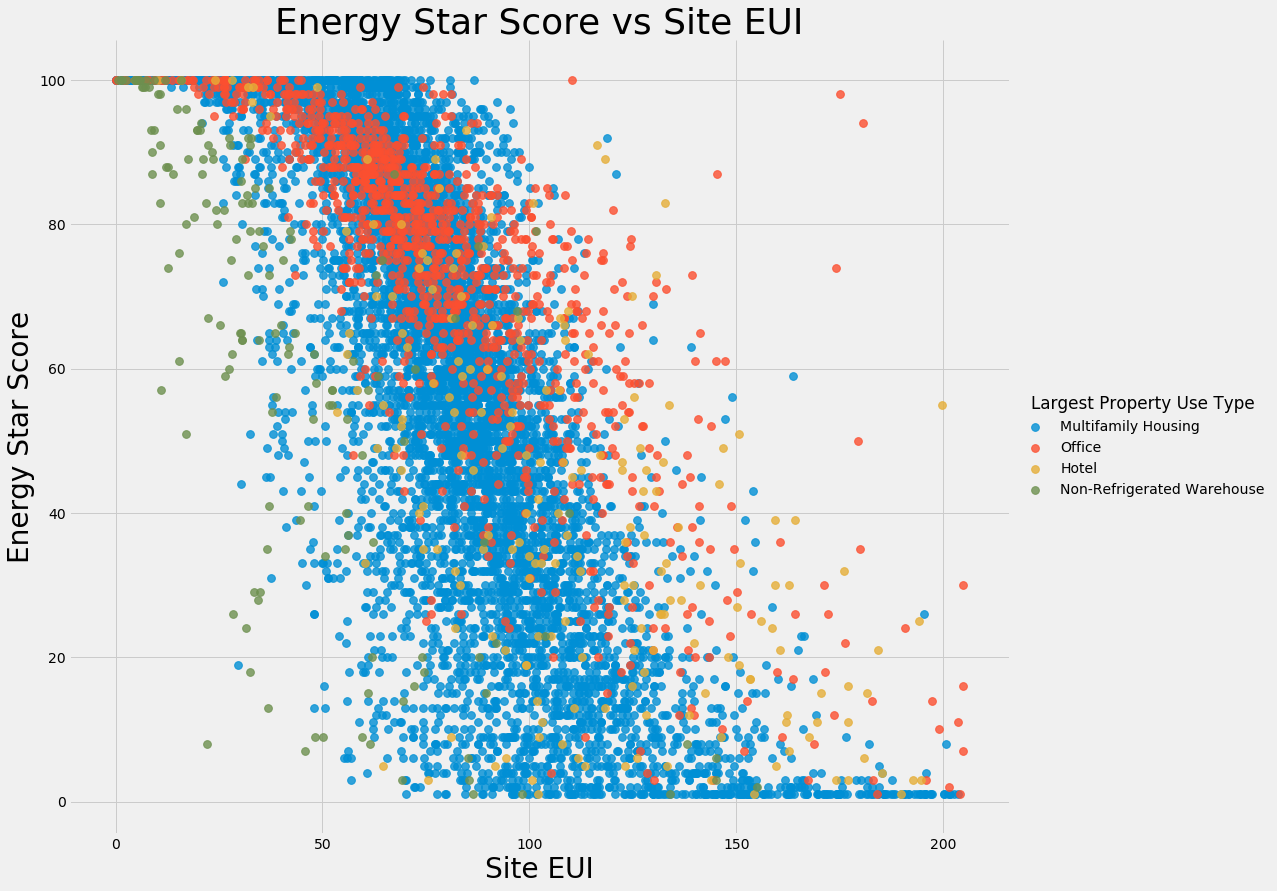

In [46]:
# fig = plt.figure(figsize=(12, 10))

# Извлекаем типы строений
features['Largest Property Use Type'] = data.dropna(subset = ['score'])['Largest Property Use Type']

# Ставим ограничение на типы зданий с более чем 100 наблюдениями
features = features[features['Largest Property Use Type'].isin(types)]


sns.lmplot('Site EUI (kBtu/ft²)', 'score', 
          hue = 'Largest Property Use Type', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          height = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("Site EUI", size = 28)
plt.ylabel('Energy Star Score', size = 28)
plt.title('Energy Star Score vs Site EUI', size = 36);

Этот график наглядно демонстрирует, что такое коэффициент корреляции со значением -0.7. Site EUI уменьшается, и рейтинг энергопотребления уверенно возрастает, независимо от типа здания.

Далее построим Pairs Plot. Это мощный исследовательский инструмент, он позволяет взглянуть на взаимосвязи сразу между несколькими признаками одновременно, а так же на их распределение. Для построения используется модуль seaborn и функция PairGrid. Построен Pairs Plot со scatterplots выше главной диагонали, гистограммами на главной диагонали и 2D kernel density plots, с указанием корреляции, ниже главной диагонали.

C:\Users\DARIA\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


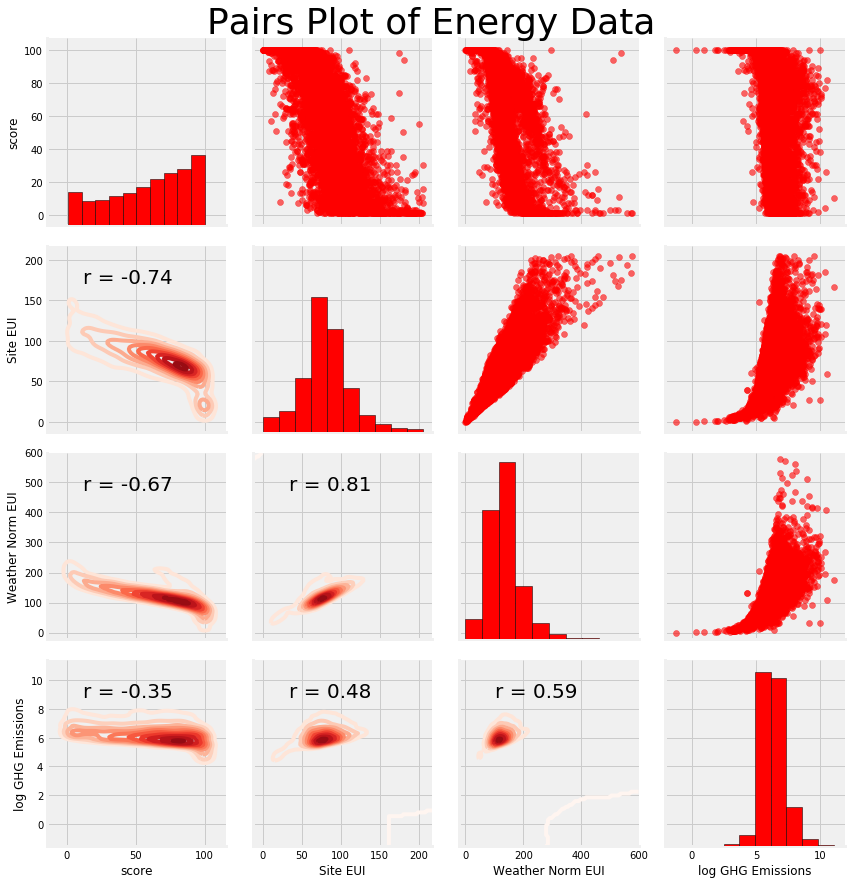

In [27]:
# Выбираем колонки для построения
plot_data = features[['score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]


plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

plot_data = plot_data.dropna()

# Функция для расчета коэффициента корреляции между двумя столбцами
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Создаём pairgrid object
grid = sns.PairGrid(data = plot_data, height = 3)

# Точечный график
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Соотношение корреляции и плотности
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);

Чтобы посмотреть на интересующие нас отношения между величинами, ищем пересечения строк и колонок. Например, чтобы взглянуть на корреляцию между Weather Norm EUI со score, смотрим на строку Weather Norm EUI  и колонку score. Видно, что коэффициент Пирсона равен -0.67. График может помочь понять, какие признаки стоит включить в нашу модель.

## Выбор и создание новых признаков

* Создание новых признаков (Feature engineering): процесс при котором берутся данные как они есть и затем на основе имеющихся данных конструируются новые признаки. Это может означать изменение непосредственно самих значений, например логарифмирование, взятие корня, или one—hot encoding категориальных признаков для того чтобы модель могла их эти признаки обработать. 
* Выбор признаков (Feature selection): процесс выбора наиболее релевантных признаков. При этом из набора удаляются признаки для того чтобы модель уделила больше внимания и ресурсов первостепенным признакам, а также это помогает получить более легкоинтерпретируемые результаты. В общем, это чистка набора при которой остаются только наиболее важные для нашей задачи данные.

Последовательность действий:

* One-hot кодирование категориальные признаков (район и тип здания);
* Логарифмирование числовых данных.
One-hot кодирование необходимо выполнить для того, чтобы модель могла учесть категориальные признаки. Модель не сможет понять, что имеется ввиду, когда указано, что здание используется как "офис". Нужно создать новый соответствующий признак и присвоить ему значение 1, если данная запись содержит сведения об офисе и 0 в противном случае.

При применении различных математических функций к значениям в наборе модель способна распознать не только линейные связи между признаками.

Логарифмируем числовые признаки, выделяем два упомянутых категориальных признака и применяем к ним one-hot кодирование. Затем объединяем полученные при этом наборы

In [28]:
features = data.copy()

numeric_subset = data.select_dtypes('number')

for col in numeric_subset.columns:
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

C:\Users\DARIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\DARIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
C:\Users\DARIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


(11319, 110)

В итоге в нашем наборе теперь всё ещё 11,000 записей (зданий) и 110 колонок (признаков). Не все эти признаки одинаково важны для нашей задачи.

## Выбор признаков
Многие из 110 признаков для нашей модели избыточны, т.к. некоторые из них сильно коррелируют. Например, зависимость Site EUI от Weather Normalized Site EUI, которая имеют коэффициент корреляции 0.997.

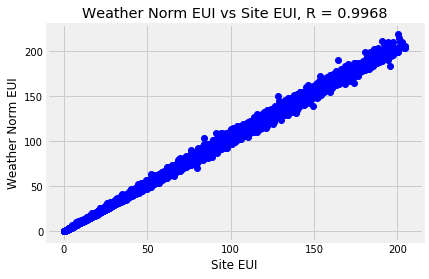

In [29]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI'); plt.ylabel('Weather Norm EUI')
plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1]);

Для поиска коллинеарных признаков используем thebcorrelation коэффициент. Один из двух признаков будет автоматически удален если коэффициент корреляции для этой пары выше 0.6. 

В итоге оставим всего  64 признака и один целевой.

In [30]:
def remove_collinear_features(x, threshold):
    y = x['score']
    x = x.drop(columns = ['score'])
    
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    x['score'] = y
               
    return x

In [31]:
features = remove_collinear_features(features, 0.6);

C:\Users\DARIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal


In [32]:
features  = features.dropna(axis=1, how = 'all')
features.shape

(11319, 65)

## Оценка результата работы алгоритма
Уже выполнена чистка данных, предварительный анализ, оставлены только полезные признаки. Последний шаг перед началом обучения модели — определение критерия, по которому можно понять, есть ли хоть какой-то толк от нашего алгоритма. 

В качестве метрики используем среднее абсолютное отклонение (mean absolute error (MAE)).

До расчета MAE, нужно разделить выборку на обучающую и проверочную (тестовую):

* Обучающая выборка это набор который подается на вход модели в процессе обучения вместе с ответами, с целью научить модель видеть связь между этими признаками и правильным ответом
* Тестовая выборка используется для проверки модели. Модель не получает целевой признак на вход и, более того, должна предсказать его величину используя значения остальных признаков. Эти предсказания потом сравниваются с реальными ответами.
Используем 70% записей для обучения и на 30% проверим работу:

In [33]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['score'].isna()]
score = features[features['score'].notnull()]

print(no_score.shape)
print(score.shape)

(1858, 65)
(9461, 65)


In [37]:
from sklearn.model_selection import train_test_split

# Separate out the features and targets
features = score.drop(columns='score')
targets = pd.DataFrame(score['score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(6622, 64)
(2839, 64)
(6622, 1)
(2839, 1)


У нас есть 1858 зданий без оценки, 6622 здания с оценкой в наборе обучения и 2839 зданий с оценкой в наборе тестирования.
Рассчитаем MAE:

In [38]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [39]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 66.00
Baseline Performance on the test set: MAE = 24.5164


При такой грубой оценке в наш интервал не попало 25 точек возможных значений целевого признака. Значения самого признака изменяются в диапазоне от 1 до 100, так что ошибка составила 25%, это не самый точный показатель

In [41]:
# Сохраняем результаты
no_score.to_csv('no_score.csv', index = False)
X.to_csv('training_features.csv', index = False)
X_test.to_csv('testing_features.csv', index = False)
y.to_csv('training_labels.csv', index = False)
y_test.to_csv('testing_labels.csv', index = False)

## Промежуточные результаты
Рассмотрены первые три характерных этапа решения задачи в машинном обучении:

* Очистка и форматирование данных;
* Предварительный анализ данных;
* Выбор наиболее полезных признаков, а так же создание новых и более репрезентативных.

Мы также определили порог, по которому будем оценивать применимость наших моделей.
Используя полученные данные можно продолжить поиск наилучшей модели и её оптимизацию для решения поставленной задачи с помощью настроек гиперпараметров с перекрёстной проверкой (кросс валидацией).

## Сравнение моделей машинного обучения

На данном этапе выполняем следующие действия:
* Сравниваем несколько моделей машинного обучения по метрике производительности
* Настраиваем гиперпараметр на лучшей модели, для её оптимизации
* Оцениваем лучшую модель на тестовом наборе

Для начала необходимо импортировать основные библиотеки, используемые для анализа данных:

In [3]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale = 2)

from sklearn.preprocessing import Imputer, MinMaxScaler

# Модели ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

Далее считываем раннее сохранённые результаты

In [4]:
# Считываем данные в датафреймы
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


Столбец баллов содержит балл "Energy Star Score" - цель, на которую направлено наше решение.
Предполагается, что оценка Energy Star Score является сравнительным измерением энергоэффективности здания, хотя в анализе выше мы видели, что при расчёте данного показателя могут возникнуть проблемы.

Ниже представлено распределение Energy Star Score.

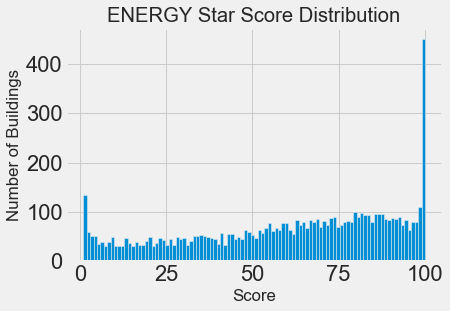

In [3]:
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('ENERGY Star Score Distribution');

На данном этапе мы создадим, обучим и оценим несколько моделей машинного обучения для нашей задачи регрессии. Цель состоит в том, чтобы определить, какая модель наиболее перспективна для дальнейшего развития.

Мы сравниваем модели, используя среднюю абсолютную ошибку. Базовая модель, которая угадывала среднее значение оценки, была в среднем на 25 баллов.

## Заполнение пропущенных значений

Стандартные модели машинного обучения не могут работать с пропущенными значениями, мы уже удалили объекты с пропущенными более чем на 50% значениями, теперь мы остановимся на заполнении этих пропущенных значений (Imputation). Мы используем простой метод замены отсутствующих значений медианой столбца.

Мы создаем объект Imputer Scikit-learn, чтобы заполнить пропущенные значения медианой столбца.
Тренировка импутера (с использованием метода Imputer.fit) проходит на данных обучения, но не на данных тестирования.
Затем мы преобразуем (используя Imputer.transform) как данные обучения, так и данные тестирования.
Это означает, что пропущенные значения в наборе тестирования заполняются медианным значением соответствующих столбцов в обучающем наборе. Это один из способов избежать утечки данных, когда информация из набора тестирования «просачивается» в процесс обучения.

In [5]:
# Создаём импутер
imputer = Imputer(strategy='median')

# Тренируем на данных обучения
imputer.fit(train_features)

# Преобразуем данные обучения и тестирования
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

C:\Users\DARIA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [7]:
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Масштабирование функций
Последний шаг, который необходимо предпринять перед построением моделей - это масштабирование функций. 
Объекты находятся в разных единицах, и нам нужно нормализовать функции, чтобы эти единицы не влияли на алгоритм. Линейная регрессия и случайный лес не требуют масштабирования объектов, но другие методы, такие как метод опорных векторов (SVM) и k nearest neighbors, требуют этого, потому что они учитывают евклидово расстояние между наблюдениями. По этой причине рекомендуется масштабировать функции при сравнении нескольких алгоритмов.

Есть два способа масштабирования функций:

* Для каждого значения вычитается среднее значение элемента и делится на стандартное отклонение элемента. Это называется стандартизацией и приводит к тому, что каждое свойство имеет среднее значение 0 и стандартное отклонение 1.
* Для каждого значения вычитается минимальное значение объекта и делится на максимум минус минимум для объекта (диапазон). Это гарантирует, что все значения для объекта находятся в диапазоне от 0 до 1 и называется масштабированием до диапазона или нормализацией.

Как и при заполнении, когда мы тренируем масштабируемый объект, мы используем только обучающий набор. Когда мы трансформируем функции, мы преобразуем как тренировочный набор, так и тестовый набор.

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(X)

X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [9]:
# Преобразовываем y в одномерный массив
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Модели для сравнения и оценки

Мы сравним пять различных моделей машинного обучения с использованием библиотеки Scikit-Learn:

* Linear Regression
* Support Vector Machine Regression
* Random Forest Regression
* Gradient Boosting Regression
* K-Nearest Neighbors Regression

Для сравнения моделей мы используем в основном значения по умолчанию для гиперпараметров модели. Как правило, они будут работать адекватно, но должны быть оптимизированы перед использованием модели. Сначала мы просто хотим определить базовую производительность каждой модели, а затем мы можем выбрать наиболее эффективную модель для дальнейшей оптимизации с помощью настройки гиперпараметра.

__Sensible defaults__: всякий раз, когда операции требуется пользовательский параметр,
соответствующее значение по умолчанию определяется библиотекой. Значение по умолчанию
должно привести к тому, что операция будет выполнена разумным способом (давая базовое
решение поставленной задачи.)

In [10]:
# Функция вычисления MAE
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Создаём, обучаем и оцениваем модель на тестовых данных
def fit_and_evaluate(model):
    
    # Train
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    return model_mae

In [11]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [12]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [13]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

C:\Users\DARIA\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 10.0073


In [14]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0144


In [15]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


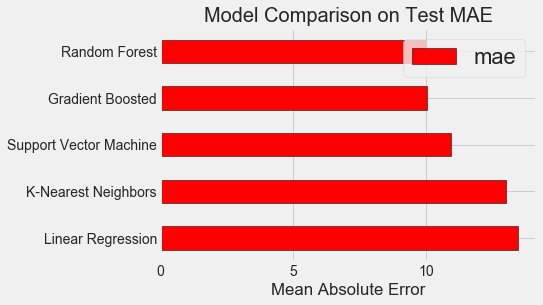

In [16]:
plt.style.use('fivethirtyeight')

model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

В зависимости от пробега (точные результаты меняются каждый раз), Gradient boosting работает лучше всего, за ним следует случайный лес. 
Конечно, это не самое справедливое сравнение, потому что мы используем в основном гиперпараметры по умолчанию. Особенно с SVM, гиперпараметры оказывают значительное влияние на производительность. (Методы случайного леса и градиентного бустинга хороши для начала, потому что производительность меньше зависит от настроек модели).

Тем не менее, на основании этих результатов мы можем сделать вывод, что машинное обучение применимо, потому что все модели значительно превосходят базовые показатели.

Для оптимизации с помощью настройки гиперпараметра мы выбрали GradientBoostingRegressor.

## Оптимизация модели

Прежде всего, нам нужно понять, какие гиперпараметры модели отличаются от параметров модели:

Настройка гиперпараметров модели управляет балансом по сравнению с подгонкой в модели. 
Проблема с выбором гиперпараметров состоит в том, что ни один набор не будет работать для всех проблем. Поэтому для каждого нового набора данных мы должны найти лучшие настройки.

## Настройка гиперпараметра со случайным поиском и перекрестной проверкой

Мы реализуем случайный поиск (Random Search) с перекрестной проверкой (Cross Validation), используя модуль RandomizedSearchCV (scikit-learn), чтобы выбрать оптимальные гиперпараметры для повышения градиента. Сначала мы определяем сетку, затем выполняем итеративный процесс: случайным образом выбираем набор гиперпараметров из сетки, оцениваем гиперпараметры с помощью 4-кратной перекрестной проверки, а затем выбираем гиперпараметры с наилучшей производительностью.

In [17]:
# Функция потери для оптимизации
loss = ['ls', 'lad', 'huber']

# Количество деревьев
n_estimators = [100, 500, 900, 1100, 1500]

# Максимальная глубина дерева
max_depth = [2, 3, 5, 10, 15]

# Минимальное количество образцов
min_samples_leaf = [1, 2, 4, 6, 8]

# Минимальное количество выборок
min_samples_split = [2, 4, 6, 10]

# Максимальное количество функций, которые следует учитывать при создании сплитов
max_features = ['auto', 'sqrt', 'log2', None]

# Определение сетки гиперпараметров для поиска
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

В приведенном ниже коде мы создаем объект рандомизированного поиска, передавая следующие параметры:

* estimator: модель
* param_distributions: распределение параметров, которые мы определили
* cv: количество сгибов, используемых для перекрестной проверки k-кратных
* n_iter: количество различных комбинаций, которые нужно попробовать
* scoring: какой показатель использовать при оценке кандидатов
* n_jobs: количество ядер для параллельной работы (-1 будет использовать все доступные)
* verbose: сколько информации отображать (1 отображает ограниченное количество)
* return_train_score: вернуть счет обучения для каждого раза перекрестной проверки
* random_state: исправляет используемый генератор случайных чисел, поэтому мы получаем одинаковые результаты при каждом запуске

In [18]:
model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [19]:
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 53.0min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

Scikit-learn использует абсолютную ошибку отрицательного среднего для оценки, т.к. хочет максимизировать показатель. Следовательно, лучший результат будет ближе к 0. Мы можем получить результаты рандомизированного поиска в датафрейме и отсортировать значения по производительности.

In [20]:
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
12      82.685003      2.151435         0.091828        0.016767   
3       91.311021      1.306495         0.088148        0.030546   
9       54.562518      4.978059         0.055883        0.010075   
0       14.937727      0.098459         0.012967        0.004283   
7       46.818195      0.590192         0.059285        0.007444   
10     384.452387     12.309483         0.320687        0.041572   
19     107.607291      1.153194         0.092358        0.014376   
2      227.477389      7.313978         0.192171        0.047740   
16     151.711354      1.727243         0.169898        0.021484   
21      25.869270      1.231221         0.091690        0.007248   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
12                500                       6                      6   
3                 500                       6                      8   
9                 500                       4                      2   
0                 100                       2                      6   
7                 500                       4                      6   
10               1100                      10                      6   
19               1100                       6                      2   
2                 500                       4                      2   
16               1500                       4                      6   
21                500                       6                      4   

   param_max_features param_max_depth param_loss  \
12               None               5        lad   
3                None               5      huber   
9                auto               3      huber   
0                auto               5         ls   
7                auto               3         ls   
10               None              10      huber   
19               auto               3        lad   
2                auto              10      huber   
16               None               3         ls   
21               log2               5      huber   

                                               params  split0_test_score  \
12  {'n_estimators': 500, 'min_samples_split': 6, ...          -8.859660   
3   {'n_estimators': 500, 'min_samples_split': 6, ...          -8.870442   
9   {'n_estimators': 500, 'min_samples_split': 4, ...          -9.133949   
0   {'n_estimators': 100, 'min_samples_split': 2, ...          -9.100775   
7   {'n_estimators': 500, 'min_samples_split': 4, ...          -9.147703   
10  {'n_estimators': 1100, 'min_samples_split': 10...          -9.257896   
19  {'n_estimators': 1100, 'min_samples_split': 6,...          -9.379266   
2   {'n_estimators': 500, 'min_samples_split': 4, ...          -9.392251   
16  {'n_estimators': 1500, 'min_samples_split': 4,...          -9.248892   
21  {'n_estimators': 500, 'min_samples_split': 6, ...          -9.394785   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
12          -8.775078          -9.325044          -9.037550        -8.999278   
3           -8.903982          -9.317120          -9.075047        -9.041601   
9           -9.042221          -9.439618          -9.153004        -9.192167   
0           -9.026372          -9.457063          -9.201235        -9.196321   
7           -9.199053          -9.698781          -9.358627        -9.350987   
10          -9.242743          -9.530568          -9.475944        -9.376750   
19          -9.382812          -9.475236          -9.291753        -9.382266   
2           -9.291198          -9.575363          -9.429866        -9.422145   
16          -9.316306          -9.798843          -9.427920        -9.447940   
21          -9.286988          -9.751767          -9.409179        -9.460643   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
12        0.210556                1           -7.027368           -6.837958   
3         0.1

In [21]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Лучшая модель градиентного бустинга имеет следующие параметры:

* loss = lad
* n_estimators = 500
* max_depth = 5
* min_samples_leaf = 6
* min_samples_split = 6
* max_features = None

Мы будем использовать поиск по сетке, которая имеет только гиперпараметр n_estimators. Мы оценим диапазон деревьев, затем построим график производительности обучения и тестирования, чтобы получить представление о том, что увеличение количества деревьев даёт нашей модели. Мы исправим другие гиперпараметры на лучшие значения, полученные при случайном поиске.

In [22]:
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [23]:
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 19.6min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samp...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

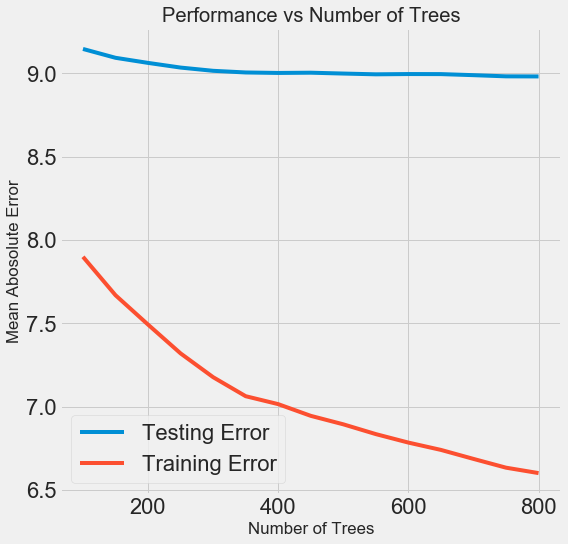

In [24]:
results = pd.DataFrame(grid_search.cv_results_)

# График ошибки обучения и тестирования в зависимости от количества деревьев
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [25]:
results.sort_values('mean_test_score', ascending = False).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14     135.712936      2.518187         0.114820        0.033363   
13     134.491051      2.292785         0.149020        0.011734   
12     128.051782      2.066129         0.141413        0.025403   
9       99.483481      1.069914         0.114071        0.011325   
11     119.005529      2.060444         0.151262        0.039872   

   param_n_estimators                 params  split0_test_score  \
14                800  {'n_estimators': 800}          -8.825290   
13                750  {'n_estimators': 750}          -8.830566   
12                700  {'n_estimators': 700}          -8.836049   
9                 550  {'n_estimators': 550}          -8.853730   
11                650  {'n_estimators': 650}          -8.851136   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
14          -8.758299          -9.296941          -9.047485        -8.981946   
13          -8.751699          -9.298411          -9.049730        -8.982544   
12          -8.755862          -9.312990          -9.053755        -8.989605   
9           -8.756938          -9.325492          -9.042721        -8.994663   
11          -8.755401          -9.325190          -9.052215        -8.995928   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
14        0.210990                1           -6.739448           -6.648109   
13        0.212523                2           -6.772908           -6.660453   
12        0.216159                3           -6.812928           -6.695770   
9         0.216865                4           -7.003413           -6.781878   
11        0.218168                5           -6.864375           -6.721452   

    split2_train_score  split3_train_score  mean_train_score  std_train_score  
14           -6.486269           -6.530287         -6.601028         0.099437  
13           -6.520818           -6.579989         -6.633542         0.094501  
12           -6.611240           -6.624919         -6.686214         0.079884  
9            -6.809121           -6.745712         -6.835031         0.099783  
11           -6.708191           -6.666758         -6.740194         0.074480

Из графика видно, что ошибка обучения значительно ниже, чем ошибка тестирования. Это ощначает, что модель очень хорошо изучает данные обучения, но затем не может применить их на тестовых данных также хорошо. 

Всегда будет разница между ошибкой обучения и ошибкой тестирования (ошибка обучения всегда меньше), но если есть существенная разница, надо попытаться уменьшить переоснащение, либо получая больше данных обучения, либо уменьшая сложность модели через настройку гиперпараметра или регуляризацию. Для GBR некоторые параметры включают уменьшение количества деревьев, уменьшение максимальной глубины каждого дерева и увеличение минимального количества выборок в листовом узле. На данный момент мы будем использовать модель с наилучшими характеристиками и допустим, что она может соответствовать учебному набору.

Основываясь на результатах перекрестной проверки, лучшая модель использует 800 деревьев и достигает ошибки перекрестной проверки ниже 9. Это указывает на то, что средняя оценка перекрестной проверки для показателя Energy Star находится в пределах 9 баллов от истинного ответа.

## Оценка окончательной модели на тестовом наборе данных

Приведенный ниже код создает окончательную модель, обучает ее (с учетом времени) и оценивает набор тестовых данных.

In [26]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

3.03 s ± 63.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [29]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

51 s ± 2.36 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [30]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0130.
Final model performance on the test set:   MAE = 9.0453.


Последняя модель превосходит базовую модель примерно на 10%, но за счет значительного увеличения времени работы (она примерно в 15 раз медленнее)
В данном случае увеличение времени выполнения не является препятствием, поскольку, хотя относительная разница велика, абсолютная величина времени обучения не значительна.

Чтобы получить представление о прогнозах, мы можем построить распределение истинных значений в тестовом наборе и прогнозных значений в тестовом наборе.

C:\Users\DARIA\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


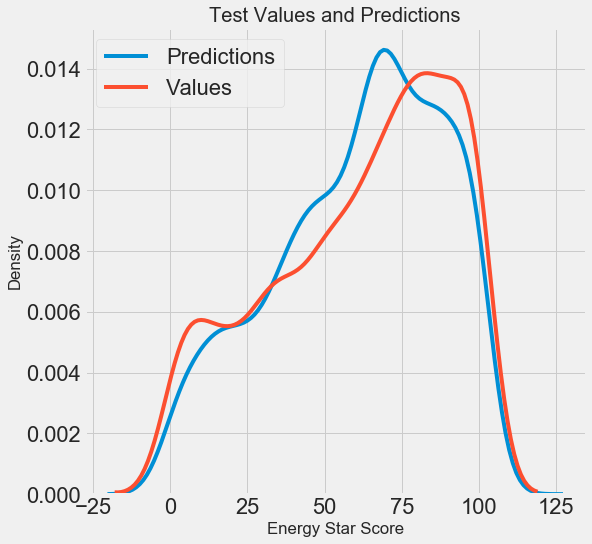

In [31]:
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

Распределение выглядит почти одинаковым, хотя плотность прогнозируемых значений ближе к медиане тестовых значений, чем к фактическому пику в 100. Кажется, что модель может быть менее точной при прогнозировании экстремальных значений и вместо этого прогнозирует значения ближе к медиане.

Другой диагностический график - гистограмма остатков. В идеале, мы хотели бы надеяться, что остатки обычно распределяются, а это означает, что модель ошибочна в одном и том же количестве в обоих направлениях (высокий и низкий).

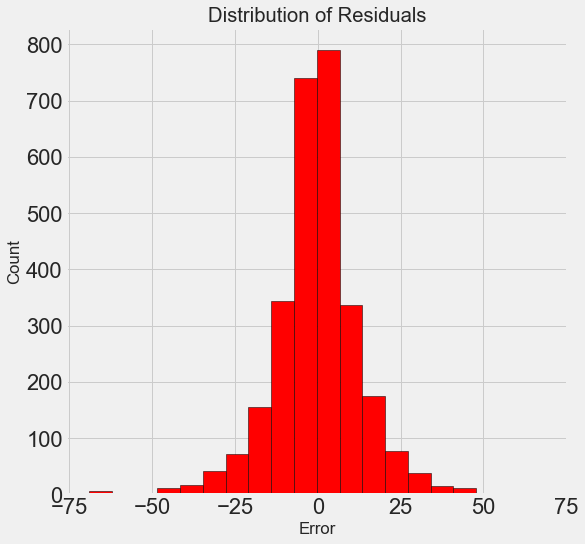

In [33]:
residuals = final_pred - y_test

plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

Остатки близки к нормально распределенным, с несколькими заметными выбросами на нижнем конце. Это указывает на ошибки, где оценка модели была намного ниже, чем истинное значение.

## Финальная модель

In [35]:
from IPython.core.pylabtools import figsize
!pip install lime
import lime 
import lime.lime_tabular

  Running setup.py bdist_wheel for lime: started
  Running setup.py bdist_wheel for lime: finished with status 'done'
  Stored in directory: C:\Users\DARIA\AppData\Local\pip\Cache\wheels\c1\38\e7\50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Running setup.py bdist_wheel for progressbar: started
  Running setup.py bdist_wheel for progressbar: finished with status 'done'
  Stored in directory: C:\Users\DARIA\AppData\Local\pip\Cache\wheels\c0\e9\6b\ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [36]:
imputer = Imputer(strategy='median')

imputer.fit(train_features)

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

C:\Users\DARIA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [37]:
# MAE
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [38]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
#  Прогнозируем на тестовом наборе
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.0839


## Интерпретируем модель

Мы рассмотрим несколько способов интерпретации нашей модели:

* Feature importances (Важность функции)
* Locally Interpretable Model-agnostic Explainer (LIME)
* Examining a single decision tree in the ensemble.

## Feature Importances

Один из основных способов интерпретации множества деревьев решений - это важность функций. Они могут быть интерпретированы как переменные, которые являются наиболее прогнозирующими. Мы можем использовать относительные значения для сравнения функций и определения, какие из них наиболее актуальны для нашей проблемы.

In [40]:
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

feature  importance
0                                Site EUI (kBtu/ft²)    0.452163
1  Weather Normalized Site Electricity Intensity ...    0.249107
2      Water Intensity (All Water Sources) (gal/ft²)    0.056662
3                                        Property Id    0.031396
4  Largest Property Use Type_Non-Refrigerated War...    0.025153
5                               DOF Gross Floor Area    0.025003
6  log_Water Intensity (All Water Sources) (gal/ft²)    0.022335
7      Largest Property Use Type_Multifamily Housing    0.021462
8                                              Order    0.020169
9        log_Direct GHG Emissions (Metric Tons CO2e)    0.019410

The Site Energy Use Intensity, Site EUI (kBtu/ft²), и the Weather Normalized Site Electricity Intensity, Weather Normalized Site Electricity Intensity (kWh/ft²) являются двумя наиболее важными характеристиками с довольно большим запасом. После этого относительная важность значительно снижается, что указывает на то, что нам может не понадобиться сохранять все функции для создания модели без потери производительностью.

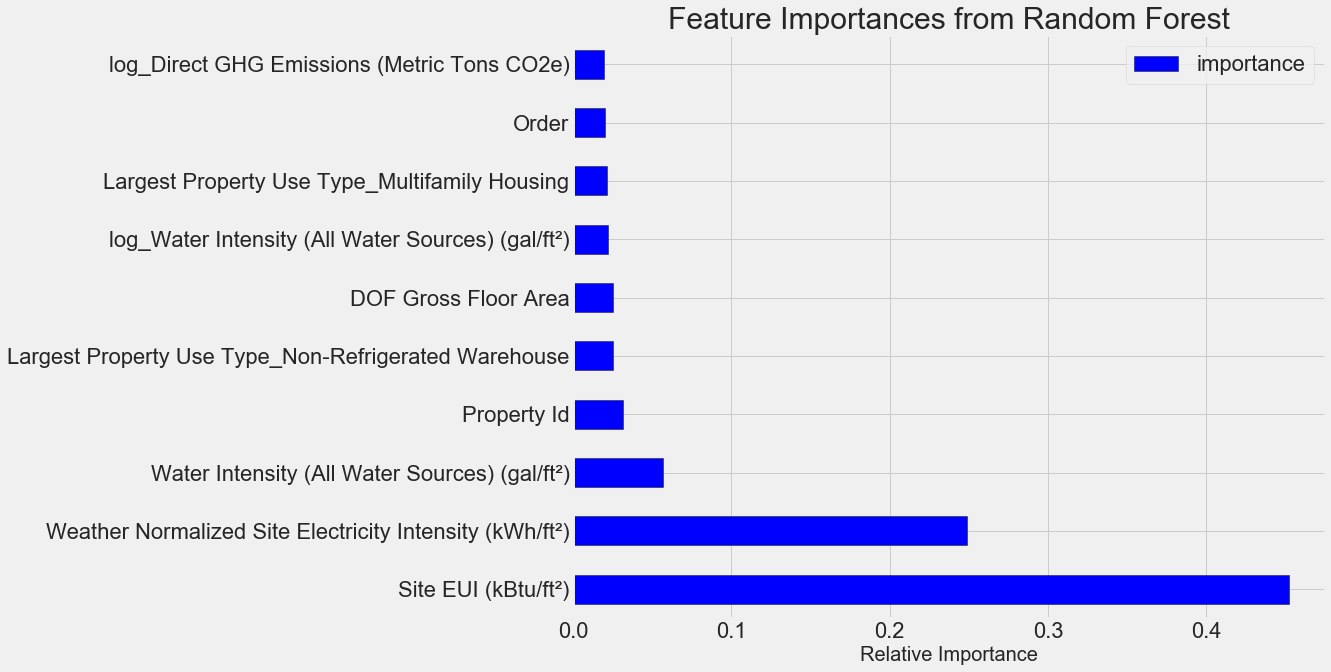

In [41]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## Использование Feature Importances для Feature Selection

Учитывая, что не каждая функция важна для нахождения оценки, что произойдет, если мы используем более простую модель, такую как линейная регрессия, с подмножеством наиболее важных функций из случайного леса? Линейная регрессия действительно превзошла базовую линию, но она не показала хороших результатов по сравнению с более сложными моделями. Мы попробуем использовать только 10 наиболее важных функций в линейной регрессии, чтобы увидеть, улучшается ли производительность.

In [42]:
most_important_features = feature_results['feature'][:10]

indices = [list(train_features.columns).index(x) for x in most_important_features]

X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [43]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4651.
Linear Regression Reduced Results: MAE = 14.5095.


Сокращение функций не улучшило результаты линейной регрессии. Оказывается, дополнительная информация в функциях с низкой важностью действительно повышает производительность.

Посмотрим, как использование сокращенного набора функций в GBR влияет на производительность.

In [44]:
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.3735


Результаты модели немного хуже с уменьшенным набором функций, поэтому мы сохраним все функции для финальной модели.

## Locally Interpretable Model-agnostic Explanations

Мы рассмотрим использование LIME для объяснения индивидуальных прогнозов, сделанных моделью. LIME - это относительно новая методика, направленная на то, чтобы показать, как мыслит модель машинного обучения, аппроксимируя область вокруг прогноза линейной моделью.

In [45]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [46]:
# Создаём lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 16.3665
Actual Value: 96.0000


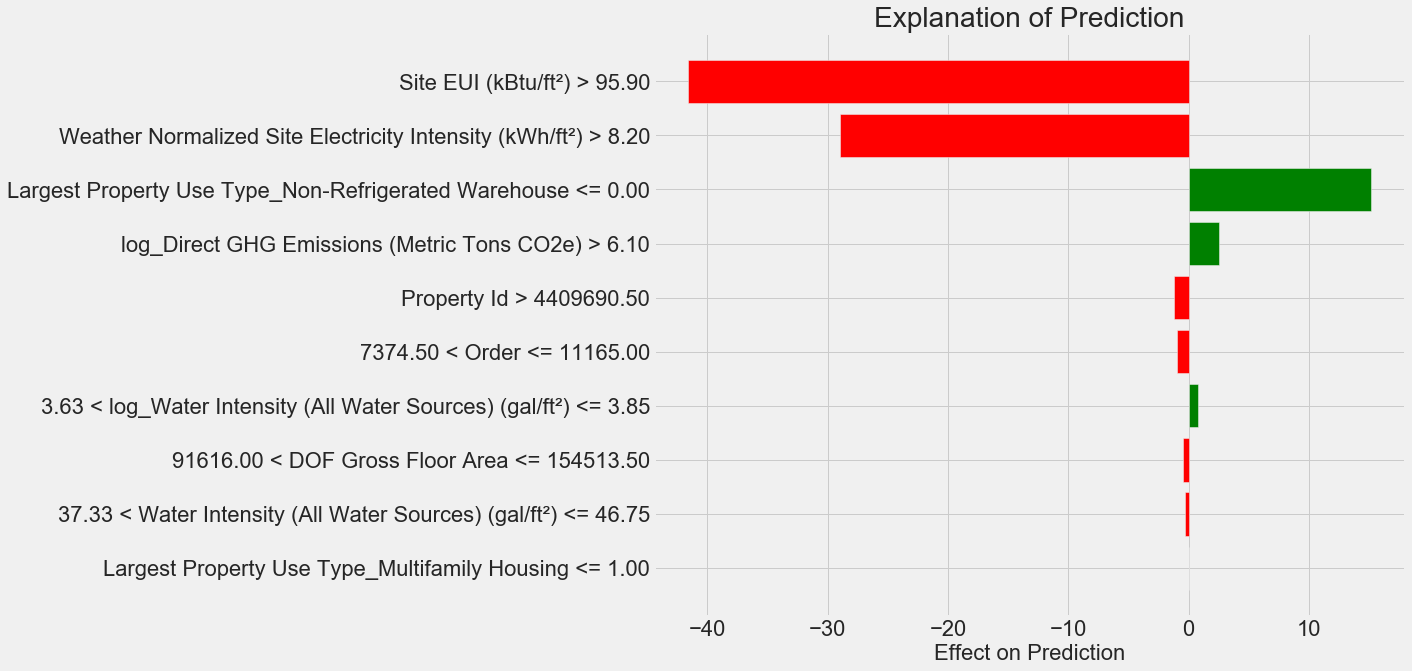

In [47]:
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [48]:
wrong_exp.show_in_notebook(show_predicted_value=False)

В этом примере наша модель предсказала оценку 12,86, а фактическое значение было 100.

График LIME показывает нам вклад в окончательный прогноз от каждой функции для примера. Мы видим, что Site EUI заметно снизил прогноз, потому что он был выше 95,50. The Weather Normalized Site Electricity Intensity, с другой стороны, повысила прогноз, потому что она была ниже 3,80.

Мы можем интерпретировать это как высказывание, что наша модель считала, что показатель Energy Star будет намного ниже, чем на самом деле, потому что Site EUI был высоким. Однако в этом случае оценка была 100, несмотря на высокое значение EUI. Хотя эта существенная ошибка (на 88 баллов) поначалу могла сбивать с толку, теперь мы можем видеть, что в действительности модель решала проблему и только что достигла неверного значения. Человек, проходящий тот же процесс, вероятно, пришел бы к такому же выводу.

Теперь мы можем пройти тот же процесс с предсказанием, что модель оказалась правильной.

Prediction: 100.0000
Actual Value: 100.0000


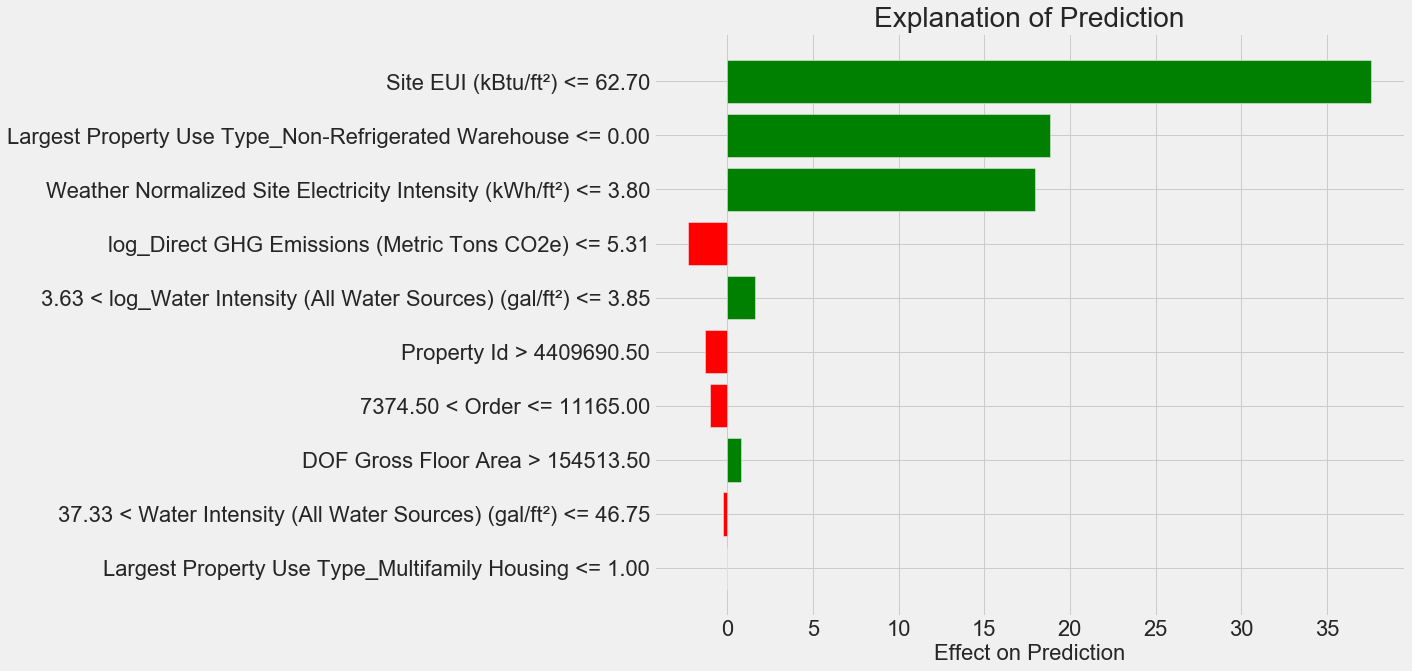

In [49]:
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [50]:
right_exp.show_in_notebook(show_predicted_value=False)

График LIME снова показывает вклад в прогноз каждой из характерных переменных для примера. Например, поскольку показатель EUI был меньше 62,70, это значительно повысило оценку оценки. Аналогичным образом, год постройки, составивший менее 1927 года, также положительно повлиял на окончательный прогноз.

Наблюдение таких графиков позволяет нам получить представление о том, как модель делает прогноз. Это, вероятно, наиболее ценно для случаев, когда модель в значительной степени отключена, поскольку мы можем проверить ошибки и, возможно, разработать более совершенные функции или скорректировать гиперпараметры модели, чтобы улучшить прогнозирование в следующий раз. Модель резко недооценила балл Energy Star для первого здания из-за повышенной EUI площадки. Поэтому мы могли бы спросить, почему у здания такой высокий показатель Energy Star, хотя у него такой высокий показатель EUI. Такой процесс, когда мы пытаемся работать с алгоритмом машинного обучения, чтобы понять проблему, кажется гораздо лучше, чем просто позволить модели делать предсказания и полностью доверять им.

## Examining a Single Decision Tree

С помощью tree-based ensemble мы можем взглянуть на любой отдельный оценщик. Хотя наша окончательная модель состоит из 800 деревьев решений, и рассмотрение одного из них не является показателем всей модели, она все же позволяет нам увидеть общее представление о том, как работает дерево решений. Отсюда естественное продолжение - представить, как сотни этих деревьев строят ошибки предыдущих деревьев, чтобы сделать окончательный прогноз.

Сначала мы извлечем дерево из леса, а затем сохраним его с помощью sklearn.tree.export_graphviz. Это сохраняет дерево в виде файла .dot, который можно преобразовать в png

In [81]:
from sklearn import tree

# Extract a single tree
single_tree = model_reduced.estimators_[105][0]

dot_data = tree.export_graphviz(single_tree, out_file = 'tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=6,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x00000230AD093750>,
           splitter='best')

In [60]:
!pip install graphviz

In [73]:
!pip install pydot

In [78]:
!pip install pydotplus

  Running setup.py bdist_wheel for pydotplus: started
  Running setup.py bdist_wheel for pydotplus: finished with status 'done'
  Stored in directory: C:\Users\DARIA\AppData\Local\pip\Cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [86]:
# Convert to a png
# https://www.graphviz.org/
import os
from IPython.display import Image
from graphviz import Digraph
#dot -Tpng tree.dot -o tree.png
import pydot
import pydotplus
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

from IPython.core.display import Image, display
display(Image('tree.png', unconfined=True))

FileNotFoundError: [WinError 2] "dot" not found in path.

Это одно целое дерево в нашем регрессоре. Его немного сложно разобрать, потому что максимальная глубина дерева равна 5. Чтобы улучшить читаемость, мы можем ограничить максимальную глубину в вызове для экспорта нашего дерева.

In [65]:
tree.export_graphviz(single_tree, out_file = 'tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

Хотя мы явно не можем исследовать каждое дерево в нашей модели, рассмотрение одного дает нам некоторое представление о том, как наша модель делает предсказания. Фактически, этот метод, основанный на блок-схемах, очень похож на то, как человек принимает решения, отвечая на один вопрос об одном значении за раз. Ансамбли на основе дерева решений просто берут идею единого дерева решений и объединяют прогнозы многих людей, чтобы создать модель с меньшей дисперсией, чем одна оценка. Ансамбли деревьев, как правило, очень точны, а также интуитивно понятны.

## Выводы
На основе проведенного аналза можно сделать два основных вывода:

* Используя данные об энергии здания, модель машинного обучения может предсказать показатель Energy Star здания с точностью до 10 баллов.
* Наиболее важными переменными для определения показателя Energy Star являются интенсивность использования энергии, интенсивность использования электроэнергии и интенсивность использования воды.